#### MLB Leagues Regression model
-Loading data and generate heat map

-Processing data and generate idea

-Training by Regression model

In [118]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Loading mlb_dataset

In [92]:
data_url="https://projects.fivethirtyeight.com/mlb-api/mlb_elo.csv"

In [93]:
mlb_data = pd.read_csv(data_url)

### drop None value

In [94]:
mlb_data.dropna(axis=0, how='any', inplace=True)

In [95]:
mlb_data.head(5)

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2
18,2020-10-05,2020,1,d,TBD,NYY,1566.075394,1557.931446,0.515622,0.484378,...,55.816028,64.669941,8.998064,45.532032,0.428900,0.571100,1558.967129,1565.871830,3.0,9.0
19,2020-10-05,2020,1,d,OAK,HOU,1547.618027,1542.711978,0.509413,0.490587,...,54.772986,53.236862,18.961942,-1.632404,0.501194,0.498806,1529.635953,1556.298933,5.0,10.0
20,2020-10-02,2020,0,c,SDP,STL,1522.312734,1520.100045,0.550128,0.449872,...,47.400000,57.310588,-17.746023,29.444071,0.461857,0.538143,1534.038131,1509.745224,4.0,0.0
21,2020-10-02,2020,0,c,CHC,FLA,1517.011886,1478.403936,0.617874,0.382126,...,60.622663,50.317526,40.641459,5.064633,0.673112,0.326888,1517.959644,1475.108982,0.0,2.0
22,2020-10-01,2020,0,c,LAD,MIL,1596.678175,1502.693145,0.712092,0.287908,...,56.674581,57.809816,21.716845,33.175306,0.673916,0.326084,1606.065971,1506.703444,3.0,0.0


### Drawing a corr-heat_map to determing which column to modify.

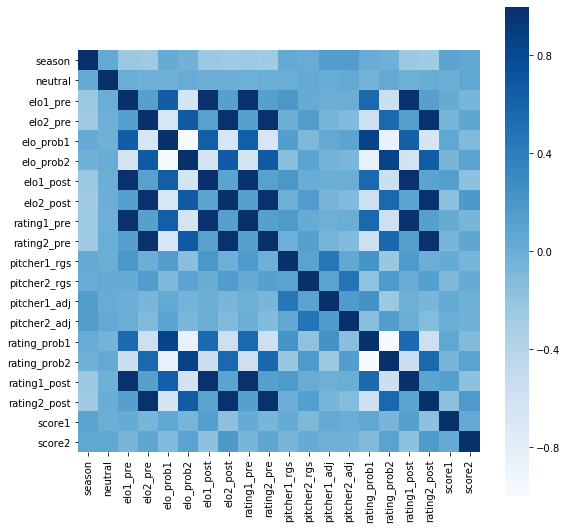

In [96]:
plt.subplots(figsize=(9, 9)) # 设置画面大小
dfData = mlb_data.corr()
sns.heatmap(dfData, annot=False, vmax=1, square=True, cmap="Blues")

#### According to the map, i have idea which based on heat of map to create two dataset, and sepratly predicting Home team and away team.
#### one for score 1 which is Home team's score,i will remove 'date','playoff','season',"neutral",'rating2_post','elo2_post','rating_prob2'
#### for score 2 which is Away team's score, i will remove 'date','playoff','season',"neutral",'rating1_post','elo1_post','rating_prob1'

## Processing data
#### Encoding team name and pitcher name to number. and create two talbe for home team, and away team (mlb_data1,mlb_data2)

In [97]:
team1 = preprocessing.LabelEncoder()
team2 = preprocessing.LabelEncoder()
pitcher1 = preprocessing.LabelEncoder()
pitcher2 = preprocessing.LabelEncoder()
mlb_data['team1'] = team1.fit_transform(mlb_data['team1'])
mlb_data['team2'] = team2.fit_transform(mlb_data['team2'])
mlb_data['pitcher1'] = pitcher1.fit_transform(mlb_data['pitcher1'])
mlb_data['pitcher2'] = pitcher2.fit_transform(mlb_data['pitcher2'])

mlb_data1 = mlb_data.drop(columns=['date','playoff','season',"neutral",'rating2_post','elo2_post','rating_prob2','pitcher2'])
mlb_data2 = mlb_data.drop(columns=['date','playoff','season',"neutral",'rating1_post','elo1_post','rating_prob1','pitcher1'])

In [106]:
mlb_data1.head(5)

,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,rating1_pre,rating2_pre,pitcher1,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating1_post,score1,score2
18,26,18,1566.075394,1557.931446,0.515622,0.484378,1560.900986,1562.032965,1562.805994,9,55.816028,64.669941,8.998064,45.532032,0.428900,1558.967129,3.0,9.0
19,19,12,1547.618027,1542.711978,0.509413,0.490587,1543.065786,1532.981409,1552.953477,23,54.772986,53.236862,18.961942,-1.632404,0.501194,1529.635953,5.0,10.0
20,22,25,1522.312734,1520.100045,0.550128,0.449872,1525.832831,1530.728125,1513.055229,33,47.400000,57.310588,-17.746023,29.444071,0.461857,1534.038131,4.0,0.0
21,5,11,1517.011886,1478.403936,0.617874,0.382126,1513.409248,1520.999030,1472.069596,156,60.622663,50.317526,40.641459,5.064633,0.673112,1517.959644,0.0,2.0
22,14,15,1596.678175,1502.693145,0.712092,0.287908,1598.290926,1604.605528,1508.163888,28,56.674581,57.809816,21.716845,33.175306,0.673916,1606.065971,3.0,0.0


### RandomForest Regression model to determin the score by other column

#### Home team predict

In [141]:
X= mlb_data1.drop(["score1","score2"], axis=1)
y= mlb_data1[["score1"]]
X_train1, X_validation1, y_train1, y_validation1 = train_test_split(X, y, test_size=0.20, random_state=0)

In [142]:
print()
print("RandomForest Regression accuracy for Home team: ")
model = RandomForestRegressor(n_estimators=9, random_state=0)
model.fit(X_train1, y_train1)
y_pred = model.predict(X_validation1)
accuracy_score(y_validation1, y_pred.round(), normalize=False)



RandomForest Regression accuracy for Home team: 


66

#### Away team predict

In [143]:
X= mlb_data2.drop(["score1","score2"], axis=1)
y= mlb_data2[["score2"]]
X_train1, X_validation1, y_train1, y_validation1 = train_test_split(X, y, test_size=0.20, random_state=0)


In [144]:
print()
print("RandomForest Regression accuracy for Away team: ")
model = RandomForestRegressor(n_estimators=9, random_state=0)
model.fit(X_train1, y_train1)
y_pred = model.predict(X_validation1)
accuracy_score(y_validation1, y_pred.round(), normalize=False)


RandomForest Regression accuracy for Away team: 


51

### Conclusion
####    In terms of accuracy, RandomForest regression is acceptable. It can be seen from the results that the prediction accuracy_score of the home team （61%） and the away team（51%） is more accurate. I also tried linear and decision tree regression model. But the results were not satisfactory. I think the reason for the higher accuracy of the random forest regression model is that this model is better at dealing with high-dimensional data. And this model can judge the importance ，correlation of the data very well
